In [1]:
import json
import os
import requests
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
# Step 1: Load the JSON data
with open('bcs_dataset_new.json', 'r') as f:
    data = json.load(f)
print(len(data))

34


[7.0, 6.0, 5.0, 5.0, 5.0, 6.0, 9.0, 6.0, 5.0, 4.0, 6.0, 4.0, 4.0, 5.0, 7.0, 4.0, 6.0, 4.0, 6.0, 3.0, 4.0, 5.0, 8.0, 3.0, 3.0, 3.0, 4.0, 3.0, 5.0, 5.0, 5.0, 6.0]
(array([5, 7, 0, 9, 0, 7, 2, 0, 1, 1]), array([3. , 3.6, 4.2, 4.8, 5.4, 6. , 6.6, 7.2, 7.8, 8.4, 9. ]))


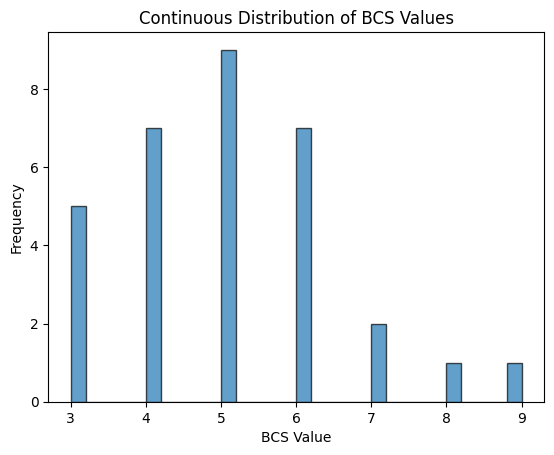

In [4]:
# Plot the distribution of BCS values
import matplotlib.pyplot as plt
bcs_values = [float(entry['BCS']) for entry in data if 'BCS' in entry and entry['BCS'] not in ['ไม่ระบุ (ไม่ทราบ)', 'ไม่ระบุ', 'ไม่ทราบ']]
# plt.hist(bcs_values, bins=range(1, 11), align='left', rwidth=0.8)
# plt.xlabel('BCS Value')
# plt.ylabel('Frequency')
# plt.title('Distribution of BCS Values')
# plt.xticks(range(1, 10))
# plt.show()
print(bcs_values)
plt.hist(bcs_values, bins=30, edgecolor='black', alpha=0.7)
print(np.histogram(bcs_values))
plt.xlabel('BCS Value')
plt.ylabel('Frequency')
plt.title('Continuous Distribution of BCS Values')
plt.show()

In [10]:
import cv2
# Step 2: Prepare the data (images and labels)
images = []
bcs_labels = []

for entry in data:
    if 'ภาพด้านบน (Top View)' in entry:
        image_path = os.path.join('bcs_dataset', entry['ภาพด้านบน (Top View)'])
        if os.path.exists(image_path):
            # Read and resize the image
            img = cv2.imread(image_path)
            img = cv2.resize(img, (224, 224))
            images.append(img)

            # Round and convert BCS
            bcs_value = float(entry['BCS1'])
            bcs_value = int((bcs_value - 2.50)/0.25)
            bcs_labels.append(bcs_value)
        else:
            print(f"Missing image: {image_path}")

X = np.array(images) / 255.0
y = np.array(bcs_labels)
print(y)

Missing image: bcs_dataset/IMG_0915 - Ratthawit Rattanawai.jpeg
Missing image: bcs_dataset/IMG_9099 - PANNAWAT SINTHUBTHONG.jpeg
Missing image: bcs_dataset/IMG_8980 - Patchareenat N.jpeg
Missing image: bcs_dataset/IMG_2570 - Pasavit TAPEN.jpeg
Missing image: bcs_dataset/IMG_0577 - Pakkaphan SAMAKWONGPANICH.jpeg
Missing image: bcs_dataset/IMG_2718 - Pasavit TAPEN.jpeg
Missing image: bcs_dataset/IMG_20250726_082932 - Khomson Satchasataporn.jpg
Missing image: bcs_dataset/IMG_20250726_083110 - Khomson Satchasataporn.jpg
Missing image: bcs_dataset/IMG_20250726_083323 - Khomson Satchasataporn.jpg
Missing image: bcs_dataset/IMG_20250726_084003 - Khomson Satchasataporn.jpg
Missing image: bcs_dataset/IMG_20250726_084722 - Khomson Satchasataporn.jpg
Missing image: bcs_dataset/IMG_20250726_084915 - Khomson Satchasataporn.jpg
Missing image: bcs_dataset/IMG_20250726_090443 - Khomson Satchasataporn.jpg
Missing image: bcs_dataset/IMG_20250726_091416 - Khomson Satchasataporn.jpg
Missing image: bcs_dat

In [106]:
from sklearn.model_selection import StratifiedShuffleSplit
# Use Stratified Shuffle Split to ensure all classes are in the test set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in splitter.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train_raw, y_test_raw = y[train_idx], y[test_idx]
print("Train class distribution:", np.bincount(y_train_raw))
print("Test labels:", y_test_raw)

# Group indices by class
# from collections import defaultdict
# class_indices = defaultdict(list)
# for idx, label in enumerate(y):
#     class_indices[label].append(idx)

# # Select 1 sample per class for the test set
# test_indices = [indices[0] for indices in class_indices.values()]

# # Remaining for training
# all_indices = set(range(len(y)))
# train_indices = list(all_indices - set(test_indices))

# # Split the data
# X_train, X_test = X[train_indices], X[test_indices]
# y_train_raw, y_test_raw = y[train_indices], y[test_indices]

# print("Train class distribution:", np.bincount(y_train_raw))
# print("Test labels:", y_test_raw)

Train class distribution: [  6  16  57  65 112   0  21  24  29]
Test labels: [3 6 4 3 6 4 2 7 2 8 7 2 2 6 3 2 4 4 2 3 2 4 8 2 4 3 4 3 2 7 3 4 4 4 4 3 3
 4 3 4 4 2 8 4 6 4 7 2 1 2 3 3 2 3 4 4 8 4 4 3 1 4 6 8 2 4 1 4 7 3 4 3 3 4
 4 1 4 4 0 7 8 2 8]


In [107]:
# Step 4: Build the model using MobileNet
base_model = MobileNet(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

In [108]:
# Freeze the layers of the base model
base_model.trainable = True

x = base_model.output
# x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(9, activation='softmax')(x)  # 9 classes (1-9 BCS)

In [109]:
# Create the model
model = Model(inputs=base_model.input, outputs=predictions)


In [110]:

# Step 5: Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',  # Sparse categorical cross-entropy for integer labels
              metrics=['accuracy'])


In [111]:
# Step 6: Train the model
history = model.fit(X_train, y_train_raw, epochs=25, batch_size=4, validation_split=0.2)
# history = model.fit(X_train, y_train_raw, epochs=25, validation_split=0.2)
# Step 7: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_raw)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - accuracy: 0.2263 - loss: 2.1912 - val_accuracy: 0.3788 - val_loss: 2.1604
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.5740 - loss: 2.1402 - val_accuracy: 0.5606 - val_loss: 2.1071
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.6779 - loss: 2.0850 - val_accuracy: 0.7273 - val_loss: 2.0559
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.7731 - loss: 2.0354 - val_accuracy: 0.8182 - val_loss: 2.0060
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.7441 - loss: 1.9793 - val_accuracy: 0.8485 - val_loss: 1.9392
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - accuracy: 0.8161 - loss: 1.8940 - val_accuracy: 0.8939 - val_loss: 1.8457
Epoch 7/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.7659 - loss: 1.8723 - val_accuracy: 0.8788 - val_loss: 1.7984
Epoch 8/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.7822 - loss: 1.7554 - val_accuracy: 0

In [112]:

# Step 7: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_raw)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Step 8: Save the model
model.save('bcs_prediction_model.h5')

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.9762 - loss: 0.5824


Test Accuracy: 97.59%


In [113]:
import numpy as np
from collections import Counter

# After you split the data
print("✅ Test set BCS distribution:")
bcs_counts = Counter(y_test_raw)
for bcs, count in sorted(bcs_counts.items()):
    print(f"BCS {bcs}: {count} samples")

print(f"\nTotal: {len(y_test_raw)} test samples")


✅ Test set BCS distribution:
BCS 0: 1 samples
BCS 1: 4 samples
BCS 2: 15 samples
BCS 3: 17 samples
BCS 4: 28 samples
BCS 6: 5 samples
BCS 7: 6 samples
BCS 8: 7 samples

Total: 83 test samples


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step


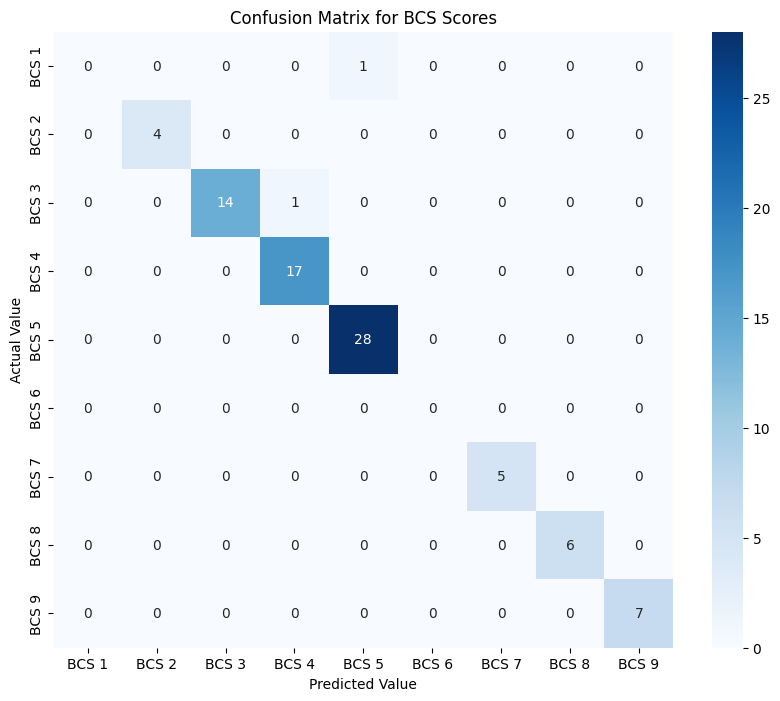


Classification Report:
              precision    recall  f1-score   support

       BCS 1       0.00      0.00      0.00         1
       BCS 2       1.00      1.00      1.00         4
       BCS 3       1.00      0.93      0.97        15
       BCS 4       0.94      1.00      0.97        17
       BCS 5       0.97      1.00      0.98        28
       BCS 6       0.00      0.00      0.00         0
       BCS 7       1.00      1.00      1.00         5
       BCS 8       1.00      1.00      1.00         6
       BCS 9       1.00      1.00      1.00         7

    accuracy                           0.98        83
   macro avg       0.77      0.77      0.77        83
weighted avg       0.96      0.98      0.97        83



In [117]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the trained model
model = load_model('bcs_prediction_model.h5')

# Predict class probabilities
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Adjust labels if you trained using BCS values 1–9
y_test_adj = y_test_raw # Only if labels were originally 1-9

# Define all BCS class labels (0–8 representing BCS 1–9)
all_labels = list(range(9))

# Create confusion matrix with all 9 classes
cm = confusion_matrix(y_test_adj, y_pred, labels=all_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'BCS {i}' for i in range(1, 10)],
            yticklabels=[f'BCS {i}' for i in range(1, 10)])
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.title('Confusion Matrix for BCS Scores')
plt.show()

# Print classification report (force inclusion of all labels)
print("\nClassification Report:")
print(classification_report(
    y_test_adj, y_pred,
    labels=all_labels,
    target_names=[f'BCS {i}' for i in range(1, 10)],
    zero_division=0  # Prevent errors if a class is missing
))


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step


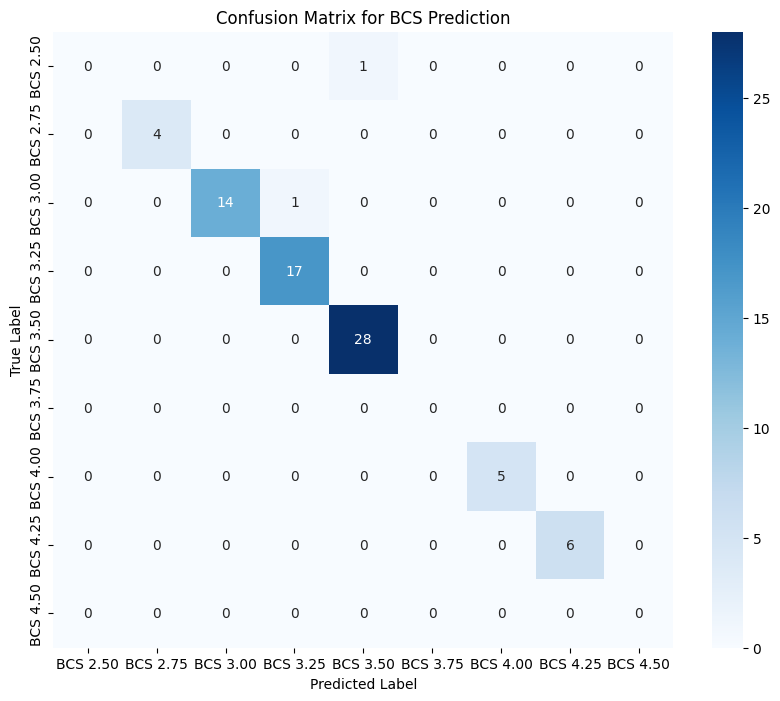


Classification Report:
              precision    recall  f1-score   support

    BCS 2.50       0.00      0.00      0.00         1
    BCS 2.75       1.00      1.00      1.00         4
    BCS 3.00       1.00      0.93      0.97        15
    BCS 3.25       0.94      1.00      0.97        17
    BCS 3.50       0.97      1.00      0.98        28
    BCS 3.75       0.00      0.00      0.00         0
    BCS 4.00       1.00      1.00      1.00         5
    BCS 4.25       1.00      1.00      1.00         6
    BCS 4.50       0.00      0.00      0.00         0

   micro avg       0.97      0.97      0.97        76
   macro avg       0.66      0.66      0.66        76
weighted avg       0.96      0.97      0.97        76



In [115]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the trained model
model = load_model('bcs_prediction_model.h5')

# Predict class probabilities
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Adjust labels if you trained using BCS values 2.50, 2.75, ..., 4.50
y_test_adj = y_test_raw  # Adjust this if necessary

# Define the new BCS class labels
class_labels = [2.50, 2.75, 3.00, 3.25, 3.50, 3.75, 4.00, 4.25, 4.50]

# Map the predicted indices to the corresponding BCS values
y_pred_adjusted = [class_labels[i] for i in y_pred]

# Map the true indices to the corresponding BCS values
y_test_adjusted = [class_labels[i] for i in y_test_adj]

# Convert the continuous BCS values to their respective class indices
bins = np.linspace(2.50, 4.50, len(class_labels) + 1)  # Define bins for BCS classes
y_true_binned = np.digitize(y_test_adjusted, bins) - 1  # Bin true labels
y_pred_binned = np.digitize(y_pred_adjusted, bins) - 1  # Bin predicted labels

# Create confusion matrix with the new BCS class labels (as indices)
cm = confusion_matrix(y_true_binned, y_pred_binned, labels=range(len(class_labels)))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'BCS {i:.2f}' for i in class_labels],
            yticklabels=[f'BCS {i:.2f}' for i in class_labels])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for BCS Prediction')
plt.show()

# Print classification report (force inclusion of all labels)
print("\nClassification Report:")
print(classification_report(
    y_true_binned, y_pred_binned,
    labels=range(len(class_labels)),
    target_names=[f'BCS {i:.2f}' for i in class_labels],
    zero_division=0  # Prevent errors if a class is missing
))
